# Coin Toss Problem

#### Can be run on Google Colaboratory

In [3]:
!pip install bijax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.9/299.9 KB 5.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached setuptools_scm_git_archive-1.4-py2.py3-none-any.whl (3.3 kB)
  Using cached setuptools_scm-7.1.0-py3-none-any.whl (43 kB)
  Created wheel for bijax: filename=bijax-0.1.1-py3-none-any.whl size=10210 sha256=a3d3509e6743832c1a15c99d76ac09dfb51d22ae525570697fddd5f9003d6ea0
  Stored in directory: /root/.cache/pip/wheels/cc/3f/32/3501af7931ac7295480b3191a3eb0e13356d9ed7c2afa6ee7c
Successfully built bijax


In [10]:
import jax
from jax.flatten_util import ravel_pytree
import jax.numpy as jnp
import optax
import tensorflow_probability.substrates.jax as tfp

tfd = tfp.distributions
tfb = tfp.bijectors

import matplotlib.pyplot as plt
import seaborn as sns

from bijax import ADVI, MCMC
from bijax.utils import train_fn

import pymc as pm
import numpy as np
import arviz as az

## Data

In [13]:
tosses = jnp.array([0, 1, 1, 1, 1, 0, 1, 1 , 1 ,1])

## Model

In [14]:
def log_likelihood_fn(latent_sample, outputs, inputs, **kwargs):
    probs = latent_sample['probability_of_heads']
    return tfd.Bernoulli(probs=probs).log_prob(outputs).sum()

def get_model1():
    a = 10.0
    b = 15.0
    prior = {'probability_of_heads': tfd.Beta(a, b)}
    bijector = {'probability_of_heads': tfb.Sigmoid()}
    return a, b, prior, bijector

a, b, prior, bijector = get_model1()

## True posterior

In [15]:
n_heads = tosses.sum()
n_tails = len(tosses) - n_heads

print(a+n_heads, b+n_tails)
true_posterior = tfd.Beta(a+n_heads, b+n_tails)

18.0 17.0


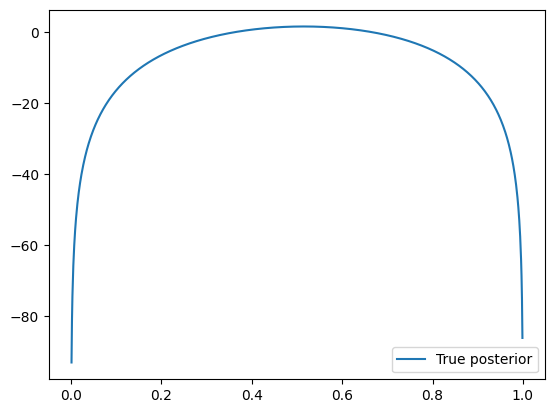

In [16]:
support = {'probability_of_heads': jnp.linspace(0, 1, 1000)}
# true_posterior.log_prob(0.1)
plt.plot(support['probability_of_heads'], true_posterior.log_prob(support['probability_of_heads']), label='True posterior')
plt.legend();

## ADVI

In [19]:
advi = ADVI(prior, bijector, log_likelihood_fn, vi_type='mean_field')

/usr/local/lib/python3.9/dist-packages/bijax/utils.py:56: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  values, treedef = jax.tree_flatten(params, is_leaf=is_leaf)
/usr/local/lib/python3.9/dist-packages/bijax/utils.py:57: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  return jax.tree_unflatten(treedef, jax.random.split(seed, len(values)))


/usr/local/lib/python3.9/dist-packages/bijax/core.py:122: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  params, treedef = jax.tree_flatten(dist)
/usr/local/lib/python3.9/dist-packages/bijax/core.py:124: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  return jax.tree_unflatten(treedef, params)


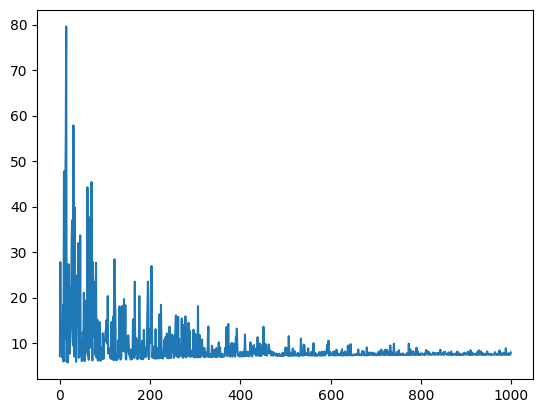

In [20]:
seed = jax.random.PRNGKey(0)
optimizer = optax.adam(learning_rate=0.01)
params = advi.init(seed=seed)
seed = jax.random.PRNGKey(1)

loss_fn = jax.tree_util.Partial(advi.loss_fn, outputs=tosses, inputs=None, full_data_size=len(tosses))
result = train_fn(loss_fn, params, optimizer, n_epochs=1000, seed=seed, return_args=['losses'])
plt.plot(result['losses']);

In [23]:
advi_posterior = advi.apply(result['params'])

{'probability_of_heads': <tfp.bijectors.Sigmoid 'sigmoid' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>}


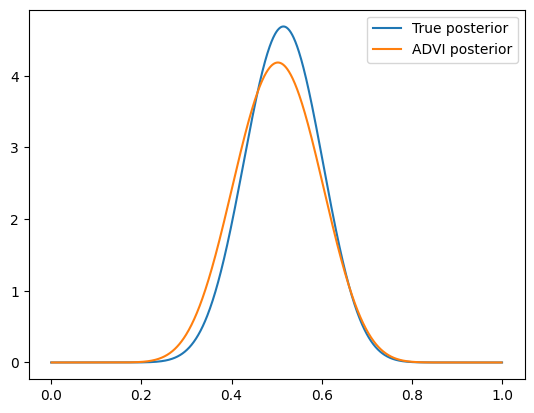

In [30]:
plt.plot(support['probability_of_heads'], true_posterior.prob(support['probability_of_heads']), label='True posterior')
plt.plot(support['probability_of_heads'], advi_posterior.prob(support, sample_shape=(len(support), )), label='ADVI posterior')
plt.legend()
plt.savefig('coin_toss.pdf')

In [28]:
plt.show()